# Tasks for laboratory assignment 2

## Extract data from the json file 

Write a script, that would extract all the the data from the json file and return it in a list of texts for further use in the next tasks

In [1]:
import json 


def extract_texts_from_file(file_path: str) -> list:
    texts = dict()
    with open(file_path) as file:
        texts = json.load(file)
        
    return texts.get("texts", [])

texts = extract_texts_from_file("resources/data.json")
print(texts)

['Oppenheimer, directed by Christopher Nolan, delves into the life of J. Robert Oppenheimer, the theoretical physicist who led the development of the atomic bomb. The film explores his moral and emotional struggles.', "Oppenheimer captures the life of the 'father of the atomic bomb' and his internal conflict after the success of the Manhattan Project. The film's complex narrative reflects on the cost of scientific achievement.", 'In Oppenheimer, Cillian Murphy delivers a riveting performance as the conflicted physicist who grapples with the consequences of his groundbreaking work on the atomic bomb, under the weight of global politics and ethics.', 'Oppenheimer is a cinematic exploration of ambition, guilt, and responsibility. Through stunning visuals and a thought-provoking story, Nolan brings the life of the brilliant but haunted physicist to the big screen.', 'Ducks are versatile waterfowl, known for their adaptability in freshwater and coastal habitats. With webbed feet and waterpr

## Process the texts

Write a script, that would process these texts. Processing should include:

- Lowercasing
- Removing Punctuation
- Removing Special Characters and Numbers
- Stemming or Lemmatization
- Handling Abbreviations
- Spelling Correction

In [2]:
import string
import re
from nltk import download as nltk_download
from nltk import WordNetLemmatizer as WNL
from autocorrect import Speller


nltk_download('wordnet')

def process_texts(texts: list) -> list:
    def lower_text(texts_: list) -> list:
        return list(map(lambda x: x.lower(), texts_))

    def remove_punctuation(texts_: list) -> list:
        return list(
            map(
                lambda x: x.translate(
                    str.maketrans('', '', string.punctuation)
                ),
                texts_
            )
        )
    
    def remove_symbols_and_nums(texts_: list) -> list:
        return list(
            map(
                lambda x: re.sub(r"[^A-Za-z\s]", '', x),
                texts_,
            )
        )
    
    def lemmatize_text(texts_: list) -> list:
        wnl = WNL()
        return list(
            map(
                lambda x: " ".join([wnl.lemmatize(word) for word in x.split()]),
                texts_
            )
        )
    
    def abb_and_spelling_correction(texts_: list) -> list:
        speller = Speller()
        abb_dict = {
            "u": "you",
            "ur": "your",
            "r": "are",
            "pls": "please",
            "pos": "please",
            "thx": "thanks",
            "j": "junior",
        }   
        return list(
            map(
                lambda x: " ".join([abb_dict.get(word, speller(word)) for word in x.split()]),
                texts_,
            )
        )
    
    formatted_text = lower_text(texts)
    formatted_text = remove_punctuation(formatted_text)
    formatted_text = remove_symbols_and_nums(formatted_text)
    formatted_text = lemmatize_text(formatted_text)
    formatted_text = abb_and_spelling_correction(formatted_text)

    return formatted_text

print(texts)
texts_processed = process_texts(texts)
print(texts_processed)

[nltk_data] Downloading package wordnet to /Users/lavr1k/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['Oppenheimer, directed by Christopher Nolan, delves into the life of J. Robert Oppenheimer, the theoretical physicist who led the development of the atomic bomb. The film explores his moral and emotional struggles.', "Oppenheimer captures the life of the 'father of the atomic bomb' and his internal conflict after the success of the Manhattan Project. The film's complex narrative reflects on the cost of scientific achievement.", 'In Oppenheimer, Cillian Murphy delivers a riveting performance as the conflicted physicist who grapples with the consequences of his groundbreaking work on the atomic bomb, under the weight of global politics and ethics.', 'Oppenheimer is a cinematic exploration of ambition, guilt, and responsibility. Through stunning visuals and a thought-provoking story, Nolan brings the life of the brilliant but haunted physicist to the big screen.', 'Ducks are versatile waterfowl, known for their adaptability in freshwater and coastal habitats. With webbed feet and waterpr

## Visualize as cloud of words

Visualize the texts as a cloud of words.

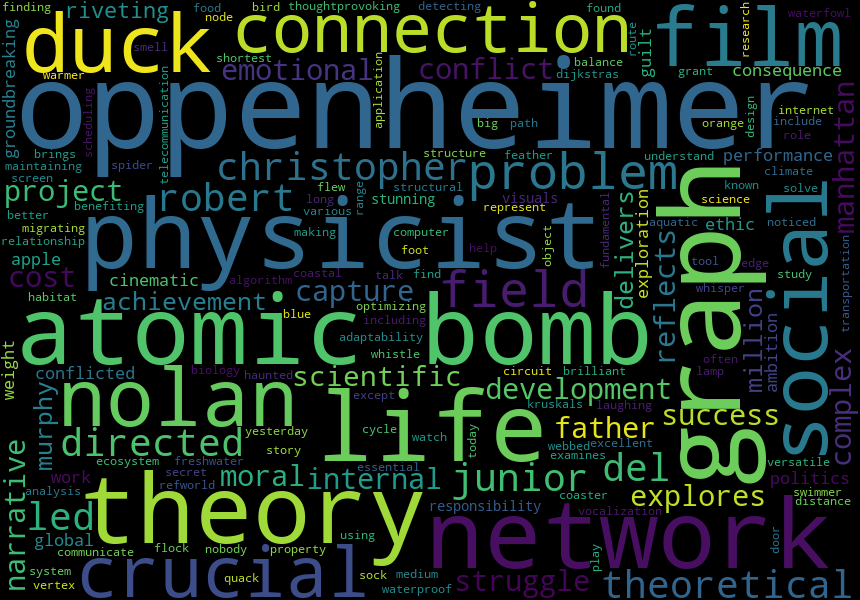

In [3]:
from wordcloud import WordCloud
from PIL import Image


def visualize_texts(texts_processed: list) -> Image:
    wc = WordCloud(width=860, height=600).generate(text="\t".join(texts_processed))
    return wc.to_image()

visualize_texts(texts_processed)

## Calculate cosine similarities using TFIDF

Calculate the TFIDF score and cosine similarity between the texts. You may use gensim, write your own script using numpy or use other module. Output the result as a matrix $n\times n$ of cosine similarity scores (where $n$ is the length of texts list).

**Extra credit**: use word2vec word embeddings in vector spaces to get better TFIDF scores by representing each word as a vector.

In [5]:
import numpy as np


def calcuate_tfidf(texts_processed: list) -> np.array:    
    document_words = [text.lower().split() for text in texts_processed]
    flatten_list = sorted(set(sum(document_words, [])))
    vocab_dict = {k:i for i,k in enumerate(flatten_list)}

    X_tf = np.zeros((len(texts_processed), len(flatten_list)), dtype=int)
    for i, doc in enumerate(document_words):
        for word in doc:
            X_tf[i, vocab_dict[word]] +=1
    
    idf = np.log(X_tf.shape[0]/X_tf.astype(bool).sum(axis=0))

    X_tfidf = X_tf * idf
    X_tfidf_norm = X_tfidf / np.linalg.norm(X_tfidf, axis=1)[:,None]
    
    return X_tfidf_norm @ X_tfidf_norm.T

cosine_matrix = calcuate_tfidf(texts_processed)
print(cosine_matrix)

[[1.00000000e+00 1.35856405e-01 1.18528744e-01 8.97270350e-02
  0.00000000e+00 9.38967663e-04 1.08387754e-02 5.23074849e-04
  5.49398674e-04 1.04693691e-02]
 [1.35856405e-01 1.00000000e+00 1.08270492e-01 5.02174070e-02
  0.00000000e+00 1.33724865e-03 2.17177540e-02 7.44946992e-04
  7.82436569e-04 2.09775711e-02]
 [1.18528744e-01 1.08270492e-01 1.00000000e+00 5.66764511e-02
  2.55095010e-02 8.72181875e-03 3.42074271e-02 2.82665151e-03
  1.48490291e-02 1.26213399e-02]
 [8.97270350e-02 5.02174070e-02 5.66764511e-02 1.00000000e+00
  1.32794501e-02 7.48543310e-02 2.97408150e-02 2.48687384e-02
  2.43298515e-02 1.03175998e-02]
 [0.00000000e+00 0.00000000e+00 2.55095010e-02 1.32794501e-02
  1.00000000e+00 2.26396983e-02 5.26416095e-02 2.10373670e-03
  3.09126094e-02 2.12601977e-03]
 [9.38967663e-04 1.33724865e-03 8.72181875e-03 7.48543310e-02
  2.26396983e-02 1.00000000e+00 2.56327438e-02 2.18720739e-02
  1.05552482e-02 2.21037460e-02]
 [1.08387754e-02 2.17177540e-02 3.42074271e-02 2.97408150e

## Visualize data

Visualize the `cosine_matrix` data using matplotlib. Choose your own method of plotting the scores in a way, that the similarity indeces between texts would be instantly visible. Plot data about texts as well (a couple of first words in the document).

*Hint: remember heat maps, aren't they nice for this task?*

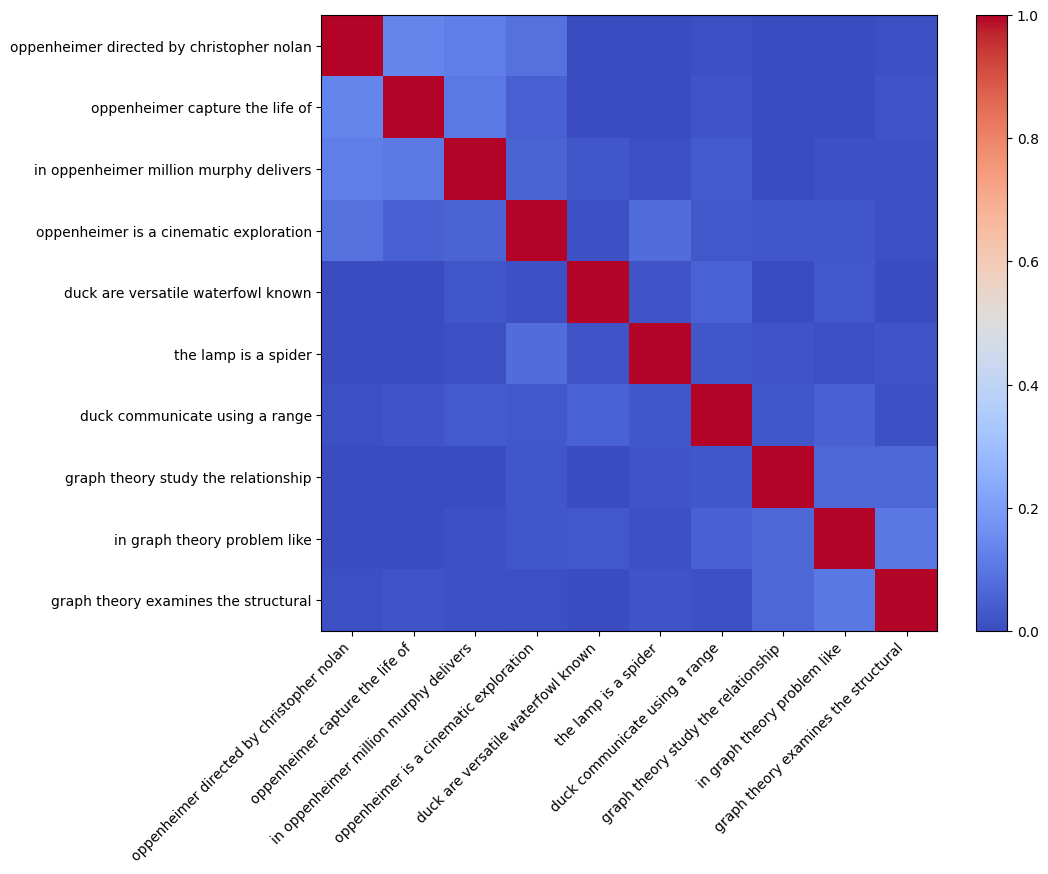

In [6]:
import matplotlib.pyplot as plt


def visualize_data(cosine_matrix: np.array, texts_processed: list):
    labels = [' '.join(text.lower().split()[:5]) for text in texts_processed]
    plt.figure(figsize=(10, 8))
    plt.imshow(cosine_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.show()


visualize_data(cosine_matrix, texts_processed)

## Analyse your own text using TFIDF (or any other method)

Analyse your own text using previous methods. You may use API fetching to get text data, download texts from Kaggle or use any texts you want. Find cosine similarities and visualize them.

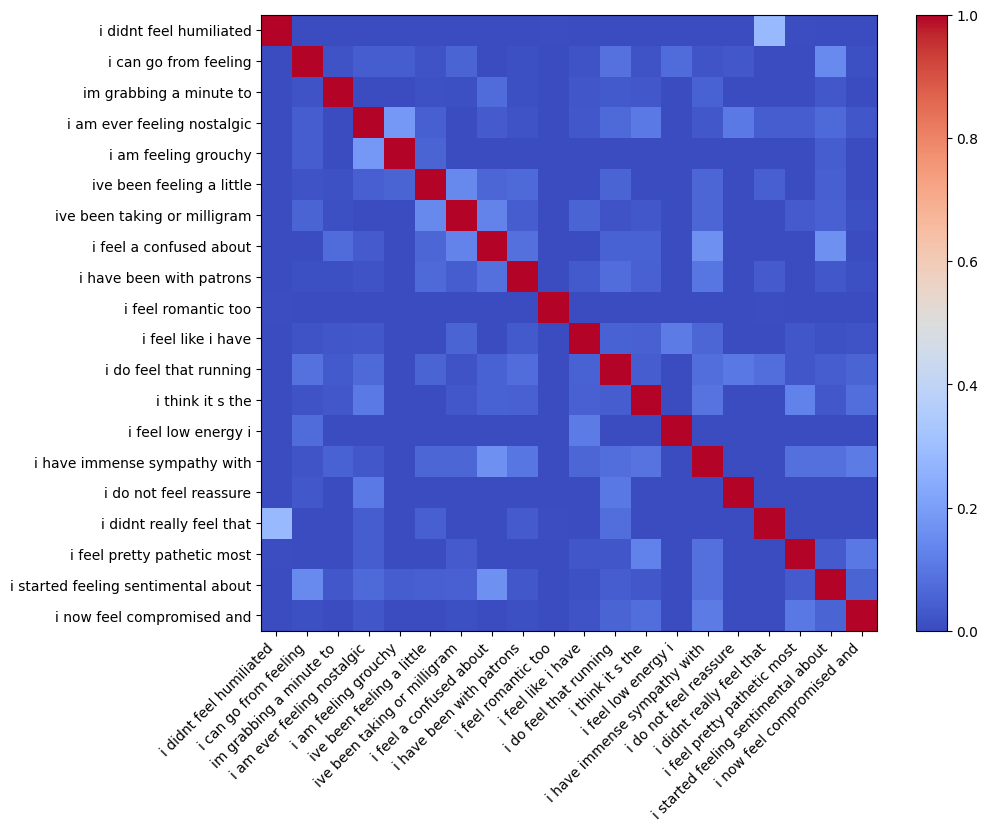

In [7]:
import pandas as pd


def get_texts():
    df = pd.read_csv("resources/Emotion_final.csv", nrows=20)
    return df["Text"].values.tolist()

texts = get_texts()
texts_processed = process_texts(texts)
visualize_texts(texts_processed)
cosine_matrix = calcuate_tfidf(texts_processed)
visualize_data(cosine_matrix, texts_processed)